# <주가 데이터 분석 및 Arima 기반 예측>

In [66]:
import FinanceDataReader as fdr
import os
import numpy as np, pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import itertools

### 1.  주가데이터 불러오기

In [67]:
data = fdr.DataReader('360750', '2020-01-01') # TIGER 미국 S&P500

In [68]:
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-08-07,9656,9671,9601,9646,123741,NaN
2020-08-10,9638,9676,9633,9670,208345,0.002488
2020-08-11,9673,9681,9658,9680,81625,0.001034
2020-08-12,9613,9637,9576,9641,66770,-0.004029
2020-08-13,9716,9716,9673,9690,160173,0.005082


In [69]:
data = data.rename(columns={'Close':'price'})
data

,Open,High,Low,price,Volume,Change
Date,,,,,,
2020-08-07,9656,9671,9601,9646,123741,NaN
2020-08-10,9638,9676,9633,9670,208345,0.002488
2020-08-11,9673,9681,9658,9680,81625,0.001034
2020-08-12,9613,9637,9576,9641,66770,-0.004029
2020-08-13,9716,9716,9673,9690,160173,0.005082
...,...,...,...,...,...,...
2024-01-09,15610,15680,15605,15680,1748882,0.013247
2024-01-10,15685,15745,15685,15715,1522027,0.002232
2024-01-11,15805,15825,15765,15765,1503556,0.003182


In [70]:
data = data.drop(['Open', 'High', 'Low','Volume', 'Change'], axis=1)
data

,price
Date,
2020-08-07,9646
2020-08-10,9670
2020-08-11,9680
2020-08-12,9641
2020-08-13,9690
...,...
2024-01-09,15680
2024-01-10,15715
2024-01-11,15765


### 데이터 시각화

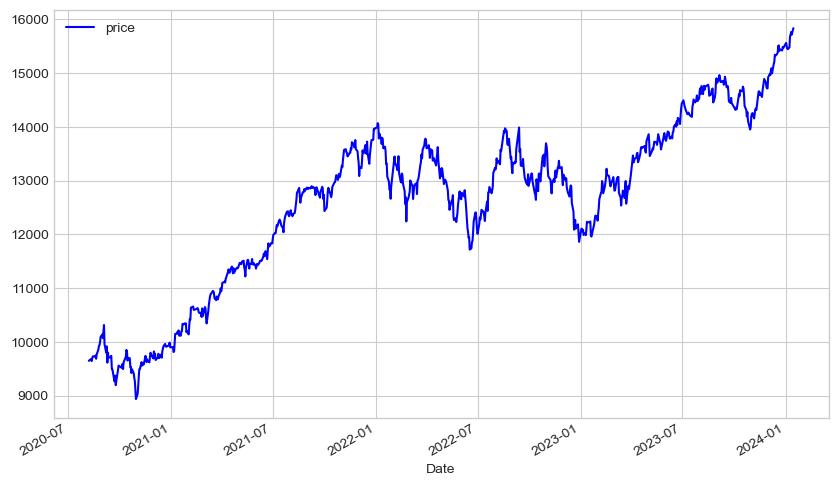

In [71]:
data.plot(figsize=(10,6), color='blue')
plt.savefig("raw_data.png", dpi=150, bbox_inches='tight')
plt.show()

### 자기상관함수(ACF), 편자기함수(PACF) 확인

c:\Users\jh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


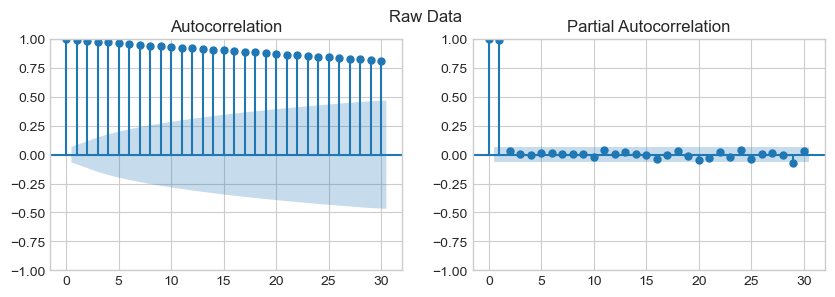

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(data.values.squeeze(),  lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=30, ax=ax[1])
plt.savefig("raw_data_ACF_PACF.png", dpi=150, bbox_inches='tight')
plt.show()

In [73]:
# acf나 pacf가 급격히 0으로 절단되는 모습을 보이지 않는다. 

### 시계열 데이터 정상과정 확인(Augmented Dicky-Fuller 검정)

In [74]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data['price'])
dftest

(-0.9739934647745999,
 0.7626310325602552,
 0,
 846,
 {'1%': -3.4381032536542913,
  '5%': -2.8649624121419746,
  '10%': -2.5685923644574107},
 10251.081930734255)

In [75]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -0.973993
p-value                          0.762631
#Lags Used                       0.000000
Number of Observations Used    846.000000
Critical Value (1%)             -3.438103
Critical Value (5%)             -2.864962
Critical Value (10%)            -2.568592
dtype: float64


In [76]:
# p value is 기준점(0.05)보다 크가 따라서 귀무가설을 기각하지 못한다. 
# 귀무가설은 통계적으로 일정한 특성이 없음(non-sationalry) 이다.
# =시간에 따라 평균이나 분산이 변함

# 따라서 현재 시계열 데이터는 통계적으로 일정한 특성이 없음(non-sationalry)

### 시계열 데이터의 정상데이터로 변환

In [77]:
## differencing 차분 : 시계열 데이터에서 현재 값과 이전 값 간의 차이를 계산하는데 사용

In [78]:
#diff_data = data.copy()
data['diff'] = data['price'].diff()
data = data.dropna()
print('########## Raw Data ##########')
print(data['diff'])

########## Raw Data ##########
Date
2020-08-10     24.0
2020-08-11     10.0
2020-08-12    -39.0
2020-08-13     49.0
2020-08-14     39.0
              ...  
2024-01-09    205.0
2024-01-10     35.0
2024-01-11     50.0
2024-01-12    -50.0
2024-01-15    120.0
Name: diff, Length: 846, dtype: float64


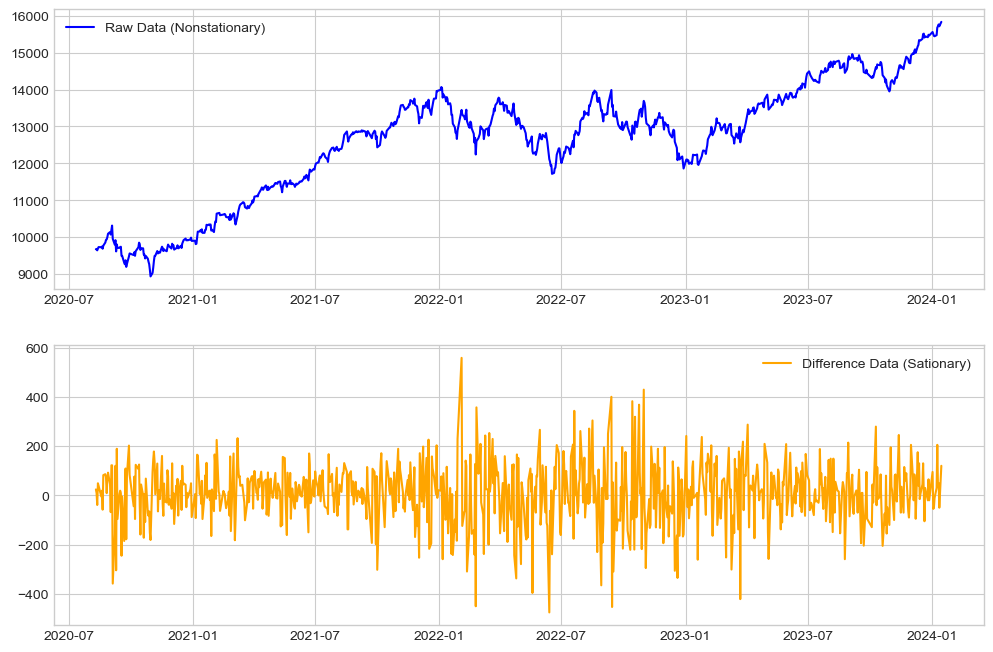

In [79]:
plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(data['price'], color='blue')
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(data['diff'], 'orange')
plt.legend(['Difference Data (Sationary)'])
plt.savefig("raw_diff.png", dpi=150, bbox_inches='tight')
plt.show()

c:\Users\jh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


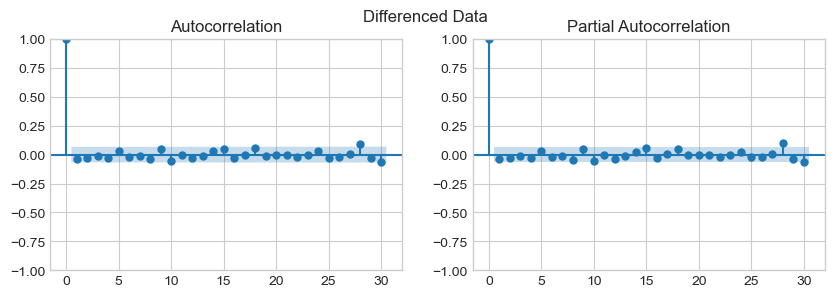

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(data['diff'].values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['diff'].values.squeeze(), lags=30, ax=ax[1])
plt.savefig("diff_data_ACF_PACF.png", dpi=150, bbox_inches='tight')
plt.show()

In [81]:
dftest2 = adfuller(data['diff'])
dftest2

(-30.072585128500336,
 0.0,
 0,
 845,
 {'1%': -3.4381124572018487,
  '5%': -2.864966469499829,
  '10%': -2.5685945257518994},
 10232.82682587772)

In [82]:
dfoutput2 = pd.Series(dftest2[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput2['Critical Value (%s)'%key] = value
print(dfoutput2)

Test Statistic                 -30.072585
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    845.000000
Critical Value (1%)             -3.438103
Critical Value (5%)             -2.864962
Critical Value (10%)            -2.568592
dtype: float64


### Arima 모델 학습

In [83]:
model = ARIMA(data['price'].values, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  846
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5246.276
Date:                Mon, 15 Jan 2024   AIC                          10500.552
Time:                        17:50:43   BIC                          10519.509
Sample:                             0   HQIC                         10507.815
                                - 846                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8608      0.120     -7.157      0.000      -1.097      -0.625
ma.L1          0.8314      0.124      6.691      0.000       0.588       1.075
ma.L2         -0.0550      0.031     -1.799      0.072      -0.115       0.005
sigma2      1.446e+04    527.164     27.432      0.000    1.34e+04    1.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               109.36
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
Ljung_box = sm.stats.acorr_ljungbox(model_fit.resid, lags=[1], return_df=True)
Ljung_box

,lb_stat,lb_pvalue
1,0.000014,0.99698


In [85]:
Ljung_box.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lb_stat    1 non-null      float64
 1   lb_pvalue  1 non-null      float64
dtypes: float64(2)
memory usage: 24.0 bytes


In [86]:
LjungBox = model_fit.test_serial_correlation('ljungbox', lags=1)
LjungBox

array([[[0.01553459],
        [0.90081028]]])

In [87]:
LjungBox.shape

(1, 2, 1)

In [88]:
LjungBox[0,1,0]

0.9008102836904217

In [89]:
LjungBox[-1]

array([[0.01553459],
       [0.90081028]])

In [91]:
round(model_fit.aic, 2)

10500.55

### Arima 모델비교

In [92]:
# parameter seacrh

In [93]:
p = range(0,4)
d = range(1,4)
q = range(0,4)
pdq = list(itertools.product(p,d,q))

In [94]:
type(pdq)

list

In [95]:
len(pdq)

48

In [96]:
AIC = []
L_Box = []

for i in pdq:
    try:
        model = ARIMA(data['price'].values, order=(i))
        model_fit = model.fit()
        LjungBox = model_fit.test_serial_correlation('ljungbox', lags=1)
        LB = LjungBox[0,1,0]
        AIC.append(round(model_fit.aic,2))
        L_Box.append(round(LB,4))
        print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)},  Ljung-Box : {round(LB,4)}')
    except:
        continue

ARIMA: (0, 1, 0) >> AIC : 10498.18,  Ljung-Box : 0.3
ARIMA: (0, 1, 1) >> AIC : 10499.29,  Ljung-Box : 0.9235
ARIMA: (0, 1, 2) >> AIC : 10500.86,  Ljung-Box : 0.904


ARIMA: (0, 1, 3) >> AIC : 10502.81,  Ljung-Box : 0.9031
ARIMA: (0, 2, 0) >> AIC : 11097.77,  Ljung-Box : 0.0
ARIMA: (0, 2, 1) >> AIC : 10493.74,  Ljung-Box : 0.3097
ARIMA: (0, 2, 2) >> AIC : 10494.73,  Ljung-Box : 0.9712
ARIMA: (0, 2, 3) >> AIC : 10496.14,  Ljung-Box : 0.9572
ARIMA: (0, 3, 0) >> AIC : 12013.81,  Ljung-Box : 0.0
ARIMA: (0, 3, 1) >> AIC : 11097.01,  Ljung-Box : 0.0


c:\Users\jh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (0, 3, 2) >> AIC : 10508.04,  Ljung-Box : 0.4593
ARIMA: (0, 3, 3) >> AIC : 10507.9,  Ljung-Box : 0.9657
ARIMA: (1, 1, 0) >> AIC : 10499.33,  Ljung-Box : 0.8892
ARIMA: (1, 1, 1) >> AIC : 10500.76,  Ljung-Box : 0.8968
ARIMA: (1, 1, 2) >> AIC : 10500.55,  Ljung-Box : 0.9008
ARIMA: (1, 1, 3) >> AIC : 10502.55,  Ljung-Box : 0.9017
ARIMA: (1, 2, 0) >> AIC : 10853.17,  Ljung-Box : 0.0
ARIMA: (1, 2, 1) >> AIC : 10494.78,  Ljung-Box : 0.9294
ARIMA: (1, 2, 2) >> AIC : 10496.44,  Ljung-Box : 0.15


c:\Users\jh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (1, 2, 3) >> AIC : 10495.92,  Ljung-Box : 0.945
ARIMA: (1, 3, 0) >> AIC : 11525.17,  Ljung-Box : 0.0
ARIMA: (1, 3, 1) >> AIC : 10855.26,  Ljung-Box : 0.0
ARIMA: (1, 3, 2) >> AIC : 10508.03,  Ljung-Box : 0.927
ARIMA: (1, 3, 3) >> AIC : 10510.34,  Ljung-Box : 0.356
ARIMA: (2, 1, 0) >> AIC : 10500.87,  Ljung-Box : 0.8984
ARIMA: (2, 1, 1) >> AIC : 10502.79,  Ljung-Box : 0.8999


c:\Users\jh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (2, 1, 2) >> AIC : 10495.96,  Ljung-Box : 0.5134
ARIMA: (2, 1, 3) >> AIC : 10504.38,  Ljung-Box : 0.8838
ARIMA: (2, 2, 0) >> AIC : 10747.54,  Ljung-Box : 0.0116
ARIMA: (2, 2, 1) >> AIC : 10496.2,  Ljung-Box : 0.9466
ARIMA: (2, 2, 2) >> AIC : 10495.92,  Ljung-Box : 0.9516
ARIMA: (2, 2, 3) >> AIC : 10491.02,  Ljung-Box : 0.5857
ARIMA: (2, 3, 0) >> AIC : 11273.14,  Ljung-Box : 0.0
ARIMA: (2, 3, 1) >> AIC : 10750.35,  Ljung-Box : 0.0129
ARIMA: (2, 3, 2) >> AIC : 10509.16,  Ljung-Box : 0.9607
ARIMA: (2, 3, 3) >> AIC : 10511.6,  Ljung-Box : 0.9276
ARIMA: (3, 1, 0) >> AIC : 10502.83,  Ljung-Box : 0.8972
ARIMA: (3, 1, 1) >> AIC : 10504.72,  Ljung-Box : 0.8973
ARIMA: (3, 1, 2) >> AIC : 10504.33,  Ljung-Box : 0.9082


c:\Users\jh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (3, 1, 3) >> AIC : 10498.48,  Ljung-Box : 0.5758
ARIMA: (3, 2, 0) >> AIC : 10697.31,  Ljung-Box : 0.0757
ARIMA: (3, 2, 1) >> AIC : 10498.12,  Ljung-Box : 0.9466
ARIMA: (3, 2, 2) >> AIC : 10500.19,  Ljung-Box : 0.9481


c:\Users\jh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (3, 2, 3) >> AIC : 10495.79,  Ljung-Box : 0.9129
ARIMA: (3, 3, 0) >> AIC : 11144.02,  Ljung-Box : 0.0001
ARIMA: (3, 3, 1) >> AIC : 10700.58,  Ljung-Box : 0.0809
ARIMA: (3, 3, 2) >> AIC : 10754.02,  Ljung-Box : 0.013
ARIMA: (3, 3, 3) >> AIC : 10512.98,  Ljung-Box : 0.936


In [97]:
# Search optimal parameters

In [98]:
result01 = list(zip(pdq, AIC,L_Box)) # 같은 위치끼지 병합

In [99]:
len(result01)

48

In [100]:
type(result01)

list

In [101]:
result01

[((0, 1, 0), 10498.18, 0.3),
 ((0, 1, 1), 10499.29, 0.9235),
 ((0, 1, 2), 10500.86, 0.904),
 ((0, 1, 3), 10502.81, 0.9031),
 ((0, 2, 0), 11097.77, 0.0),
 ((0, 2, 1), 10493.74, 0.3097),
 ((0, 2, 2), 10494.73, 0.9712),
 ((0, 2, 3), 10496.14, 0.9572),
 ((0, 3, 0), 12013.81, 0.0),
 ((0, 3, 1), 11097.01, 0.0),
 ((0, 3, 2), 10508.04, 0.4593),
 ((0, 3, 3), 10507.9, 0.9657),
 ((1, 1, 0), 10499.33, 0.8892),
 ((1, 1, 1), 10500.76, 0.8968),
 ((1, 1, 2), 10500.55, 0.9008),
 ((1, 1, 3), 10502.55, 0.9017),
 ((1, 2, 0), 10853.17, 0.0),
 ((1, 2, 1), 10494.78, 0.9294),
 ((1, 2, 2), 10496.44, 0.15),
 ((1, 2, 3), 10495.92, 0.945),
 ((1, 3, 0), 11525.17, 0.0),
 ((1, 3, 1), 10855.26, 0.0),
 ((1, 3, 2), 10508.03, 0.927),
 ((1, 3, 3), 10510.34, 0.356),
 ((2, 1, 0), 10500.87, 0.8984),
 ((2, 1, 1), 10502.79, 0.8999),
 ((2, 1, 2), 10495.96, 0.5134),
 ((2, 1, 3), 10504.38, 0.8838),
 ((2, 2, 0), 10747.54, 0.0116),
 ((2, 2, 1), 10496.2, 0.9466),
 ((2, 2, 2), 10495.92, 0.9516),
 ((2, 2, 3), 10491.02, 0.5857),
 ((2,

In [102]:
np.shape(result01)

c:\Users\jh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(48, 3)

In [103]:
result02 = np.array(result01)
result02

C:\Users\jh\AppData\Local\Temp\ipykernel_5804\2028618651.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result02 = np.array(result01)


array([[(0, 1, 0), 10498.18, 0.3],
       [(0, 1, 1), 10499.29, 0.9235],
       [(0, 1, 2), 10500.86, 0.904],
       [(0, 1, 3), 10502.81, 0.9031],
       [(0, 2, 0), 11097.77, 0.0],
       [(0, 2, 1), 10493.74, 0.3097],
       [(0, 2, 2), 10494.73, 0.9712],
       [(0, 2, 3), 10496.14, 0.9572],
       [(0, 3, 0), 12013.81, 0.0],
       [(0, 3, 1), 11097.01, 0.0],
       [(0, 3, 2), 10508.04, 0.4593],
       [(0, 3, 3), 10507.9, 0.9657],
       [(1, 1, 0), 10499.33, 0.8892],
       [(1, 1, 1), 10500.76, 0.8968],
       [(1, 1, 2), 10500.55, 0.9008],
       [(1, 1, 3), 10502.55, 0.9017],
       [(1, 2, 0), 10853.17, 0.0],
       [(1, 2, 1), 10494.78, 0.9294],
       [(1, 2, 2), 10496.44, 0.15],
       [(1, 2, 3), 10495.92, 0.945],
       [(1, 3, 0), 11525.17, 0.0],
       [(1, 3, 1), 10855.26, 0.0],
       [(1, 3, 2), 10508.03, 0.927],
       [(1, 3, 3), 10510.34, 0.356],
       [(2, 1, 0), 10500.87, 0.8984],
       [(2, 1, 1), 10502.79, 0.8999],
       [(2, 1, 2), 10495.96, 0.5134],
  

In [104]:
result02[:, 2]

array([0.3, 0.9235, 0.904, 0.9031, 0.0, 0.3097, 0.9712, 0.9572, 0.0, 0.0,
       0.4593, 0.9657, 0.8892, 0.8968, 0.9008, 0.9017, 0.0, 0.9294, 0.15,
       0.945, 0.0, 0.0, 0.927, 0.356, 0.8984, 0.8999, 0.5134, 0.8838,
       0.0116, 0.9466, 0.9516, 0.5857, 0.0, 0.0129, 0.9607, 0.9276,
       0.8972, 0.8973, 0.9082, 0.5758, 0.0757, 0.9466, 0.9481, 0.9129,
       0.0001, 0.0809, 0.013, 0.936], dtype=object)

In [105]:
result02

array([[(0, 1, 0), 10498.18, 0.3],
       [(0, 1, 1), 10499.29, 0.9235],
       [(0, 1, 2), 10500.86, 0.904],
       [(0, 1, 3), 10502.81, 0.9031],
       [(0, 2, 0), 11097.77, 0.0],
       [(0, 2, 1), 10493.74, 0.3097],
       [(0, 2, 2), 10494.73, 0.9712],
       [(0, 2, 3), 10496.14, 0.9572],
       [(0, 3, 0), 12013.81, 0.0],
       [(0, 3, 1), 11097.01, 0.0],
       [(0, 3, 2), 10508.04, 0.4593],
       [(0, 3, 3), 10507.9, 0.9657],
       [(1, 1, 0), 10499.33, 0.8892],
       [(1, 1, 1), 10500.76, 0.8968],
       [(1, 1, 2), 10500.55, 0.9008],
       [(1, 1, 3), 10502.55, 0.9017],
       [(1, 2, 0), 10853.17, 0.0],
       [(1, 2, 1), 10494.78, 0.9294],
       [(1, 2, 2), 10496.44, 0.15],
       [(1, 2, 3), 10495.92, 0.945],
       [(1, 3, 0), 11525.17, 0.0],
       [(1, 3, 1), 10855.26, 0.0],
       [(1, 3, 2), 10508.03, 0.927],
       [(1, 3, 3), 10510.34, 0.356],
       [(2, 1, 0), 10500.87, 0.8984],
       [(2, 1, 1), 10502.79, 0.8999],
       [(2, 1, 2), 10495.96, 0.5134],
  

In [106]:
result02[0]

array([(0, 1, 0), 10498.18, 0.3], dtype=object)

In [107]:
result03 = [(result02[i]) for i, j in enumerate(result02[:,2]) if j > 0.05]

In [108]:
result03

[array([(0, 1, 0), 10498.18, 0.3], dtype=object),
 array([(0, 1, 1), 10499.29, 0.9235], dtype=object),
 array([(0, 1, 2), 10500.86, 0.904], dtype=object),
 array([(0, 1, 3), 10502.81, 0.9031], dtype=object),
 array([(0, 2, 1), 10493.74, 0.3097], dtype=object),
 array([(0, 2, 2), 10494.73, 0.9712], dtype=object),
 array([(0, 2, 3), 10496.14, 0.9572], dtype=object),
 array([(0, 3, 2), 10508.04, 0.4593], dtype=object),
 array([(0, 3, 3), 10507.9, 0.9657], dtype=object),
 array([(1, 1, 0), 10499.33, 0.8892], dtype=object),
 array([(1, 1, 1), 10500.76, 0.8968], dtype=object),
 array([(1, 1, 2), 10500.55, 0.9008], dtype=object),
 array([(1, 1, 3), 10502.55, 0.9017], dtype=object),
 array([(1, 2, 1), 10494.78, 0.9294], dtype=object),
 array([(1, 2, 2), 10496.44, 0.15], dtype=object),
 array([(1, 2, 3), 10495.92, 0.945], dtype=object),
 array([(1, 3, 2), 10508.03, 0.927], dtype=object),
 array([(1, 3, 3), 10510.34, 0.356], dtype=object),
 array([(2, 1, 0), 10500.87, 0.8984], dtype=object),
 ar

In [109]:
result03 = np.array(result03)

In [110]:
min(result03[:,1])

10491.02

In [111]:
optimal = [(result03[i]) for i, j in enumerate(result03[:,1]) if j == min(result03[:,1])]

In [112]:
optimal

[array([(2, 2, 3), 10491.02, 0.5857], dtype=object)]

In [113]:
 optimal[0][0]

(2, 2, 3)

In [114]:
optimal01 =np.array(optimal)

In [115]:
optimal01[0,0]

(2, 2, 3)

In [116]:
orders = optimal01[0,0]

In [117]:
orders

(2, 2, 3)

### 최적모델로 학습

In [118]:
model_opt = ARIMA(data['price'].values, order = orders)
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  846
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -5239.511
Date:                Mon, 15 Jan 2024   AIC                          10491.022
Time:                        17:50:59   BIC                          10519.451
Sample:                             0   HQIC                         10501.916
                                - 846                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9298      0.009   -216.559      0.000      -1.947      -1.912
ar.L2         -0.9925      0.009   -113.463      0.000      -1.010      -0.975
ma.L1          0.9260      0.039     23.661      0.000       0.849       1.003
ma.L2         -0.9403      0.070    -13.370      0.000      -1.078      -0.802
ma.L3         -0.9857      0.037    -26.290      0.000      -1.059      -0.912
sigma2      1.428e+04   1.45e-05   9.83e+08      0.000    1.43e+04    1.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):               101.52
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.42e+23. Standard errors may be unstable.
"""

In [119]:
len(model_opt_fit.fittedvalues)

846

In [120]:
fit=pd.Series(model_opt_fit.fittedvalues, copy=True)

In [121]:
fit

0          0.000000
1      14503.278446
2       9828.885827
3       9694.061602
4       9740.884038
           ...     
841    15479.093870
842    15684.794774
843    15728.684721
844    15762.311930
845    15735.420987
Length: 846, dtype: float64

In [122]:
data = data.reset_index()

In [123]:
data['fittedValue'] = fit

In [124]:
data.tail()

,Date,price,diff,fittedValue
841,2024-01-09,15680,205.0,15479.093870
842,2024-01-10,15715,35.0,15684.794774
843,2024-01-11,15765,50.0,15728.684721
844,2024-01-12,15715,-50.0,15762.311930
845,2024-01-15,15835,120.0,15735.420987


### 최종 Arima 결과 출력

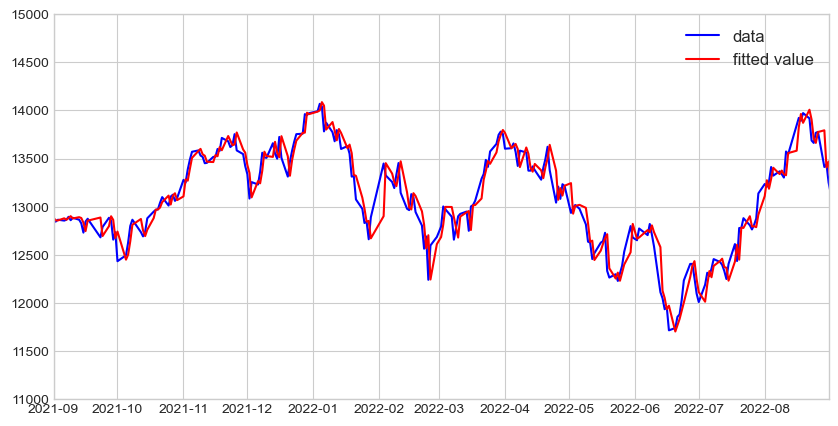

In [125]:
import datetime

plt.figure(figsize=(10,5))
plt.plot(data['Date'], data['price'], color='blue')

plt.plot(data['Date'], data['fittedValue'], color='red')
plt.legend(['data', 'fitted value'], loc='upper right', fontsize=12)
plt.xlim(datetime.date(2021,9,1), datetime.date(2022, 8,31))
plt.ylim(11000, 15000)
plt.grid(True)
plt.savefig("raw_fitted.png", dpi=150, bbox_inches='tight')
plt.show()